<a href="https://colab.research.google.com/github/SDashev/Springboard-Capstone-2/blob/master/Capstone_2_ml_model_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook uses Google colab to run


In [0]:
!pip install PyDrive

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Mar 19 16:18:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# in the colab files, I created work directory and moved the working directory there.
os.chdir( 'work')

In [0]:
download = drive.CreateFile({'id': '1-0DzB-dUXarKs6GtULkZceszlyx9BcfT'})
download.GetContentFile('fruit-recognition.zip')
#download = drive.CreateFile({'id': '1bE0dMhBKnbdA7fZCkE1CqUuL3cBVw-sL'})
#download.GetContentFile('files_for_ml_cs2.zip')

In [0]:
download = drive.CreateFile({'id': '1bE0dMhBKnbdA7fZCkE1CqUuL3cBVw-sL'})
download.GetContentFile('files_for_ml_cs2.zip')

In [0]:
!unzip -q fruit-recognition.zip  
!ls

Apple	   files_for_ml_cs2.zip   Kiwi	     Orange  Persimmon	Pomegranate
Banana	   fruit-recognition.zip  Mango      Peach   Pitaya	Tomatoes
Carambola  Guava		  muskmelon  Pear    Plum


In [0]:
!unzip -q files_for_ml_cs2.zip  
!ls

Apple			label_classes.csv  Plum
Banana			Mango		   Pomegranate
Carambola		muskmelon	   Tomatoes
filenames_shuffled.npy	Orange		   X_train_filenames.npy
files_for_ml_cs2.zip	Peach		   X_val_filenames.npy
fruit-recognition.zip	Pear		   y_labels_one_hot_shuffled.npy
Guava			Persimmon	   y_train.npy
Kiwi			Pitaya		   y_val.npy


In [0]:
!rm fruit-recognition.zip
!rm files_for_ml_cs2.zip
%reset_selective download

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [0]:
import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize

import keras

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

import matplotlib.pyplot as plt


## Build model

In [0]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(258, 320, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(3, 3)))
#model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(48, activation='relu', use_bias=True, bias_initializer='zeros' ))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))


model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 256, 318, 32)      896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 128, 159, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 126, 157, 64)      18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 42, 52, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 139776)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 48)                6709296   
_________________________________________________________________
dropout_25 (Dropout)         (None, 48)              

### Custom image data generator

Code adapted from medium.com for large data sets that do not fit in memory.

In [0]:
class My_Custom_Generator(keras.utils.Sequence):

  

  def __init__(self, image_filenames, labels, batch_size):
    self.image_filenames = image_filenames

    self.labels = labels

    self.batch_size = batch_size

    
  def __len__(self) :

    return (np.ceil(len(self.image_filenames) / float(
        self.batch_size))).astype(np.int)

  

  def __getitem__(self, idx) :

    batch_x = self.image_filenames[idx * self.batch_size : (
        idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return np.array([
            (imread(str(file_name))) for file_name in batch_x])/255.0, np.array(
                batch_y)

In [0]:
from keras.utils import to_categorical

# loading variables
X_train = np.load('X_train_filenames.npy')
y_train = to_categorical(np.load('y_train.npy'))

X_df = list(X_train)
y_df = list(y_train)

X_train_files = np.array(X_df[:44263])
y_train_values = np.array(y_df[:44263])
X_val_files = np.array(X_df[44263:])
y_val_values = np.array(y_df[44263:])

X_test_files = np.load('X_val_filenames.npy')
y_test = to_categorical(np.load('y_val.npy'))
name_classes = pd.read_csv('label_classes.csv')

In [0]:
X_train

array(['muskmelon/Muskmelon 001953.png', 'Orange/Orange0056.png',
       'Guava/Guava total/1GuavaуАВ3064.png', ...,
       'Apple/Apple D/scene01601.png', 'Carambola/Carambola 001600.png',
       'Mango/Mango0069.png'], dtype='<U46')

In [0]:
X_train_files

array(['muskmelon/Muskmelon 001953.png', 'Orange/Orange0056.png',
       'Guava/Guava total/1GuavaуАВ3064.png', ...,
       'Guava/Guava total/GuavaуАВ1327.png',
       'Kiwi/Total Number of Kiwi fruit/Kiwi00789.png',
       'Apple/Apple F/Apple F _0_3580.png'], dtype='<U46')

In [0]:
batch_size = 95

my_training_batch_generator = My_Custom_Generator(
    X_train_files, y_train_values, batch_size)
my_validation_batch_generator = My_Custom_Generator(
    X_val_files, y_val_values, batch_size)

In [0]:
# load model
load_weiths = False
if load_weiths:
  model.load_weights('/content/baseline.hdf5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[
                                                              'accuracy'])

In [0]:
# Fit the model
from keras.callbacks import EarlyStopping
early_stop_mon=EarlyStopping(patience=2)
if load_weiths!=True:
    record = model.fit_generator(generator=my_training_batch_generator,
                 steps_per_epoch = int(44263 // batch_size),
                   epochs = 6,
                   #verbose = 1,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(4917 // batch_size),
                   callbacks=[early_stop_mon])

Epoch 1/6
465/465 [==============================] - 240s 516ms/step - loss: 1.3719 - acc: 0.5433 - val_loss: 0.4103 - val_acc: 0.8797
Epoch 2/6
465/465 [==============================] - 236s 508ms/step - loss: 0.7795 - acc: 0.7075 - val_loss: 0.2981 - val_acc: 0.9096
Epoch 3/6
465/465 [==============================] - 243s 522ms/step - loss: 0.5735 - acc: 0.7811 - val_loss: 0.2315 - val_acc: 0.9254
Epoch 4/6
465/465 [==============================] - 241s 518ms/step - loss: 0.4703 - acc: 0.8168 - val_loss: 0.1886 - val_acc: 0.9343
Epoch 5/6
465/465 [==============================] - 236s 508ms/step - loss: 0.4034 - acc: 0.8425 - val_loss: 0.1770 - val_acc: 0.9379
Epoch 6/6
465/465 [==============================] - 228s 490ms/step - loss: 0.3418 - acc: 0.8655 - val_loss: 0.1575 - val_acc: 0.9443


In [0]:
save_weights = True
if save_weights:
    model.save_weights('../model/baseline.hdf5')
    #save history too
    hist_df=pd.DataFrame.from_dict(record.history)
    hist_df.to_csv('../model/history.csv')

In [0]:
model.load_weights('../model/baseline.hdf5')

In [0]:
hist=pd.read_csv('../model/history.csv')

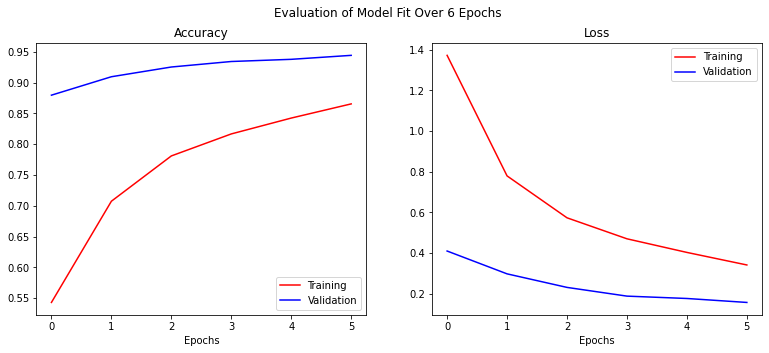

In [0]:
# Plot model fitting
# adapted from Deep Learning With Python (Chollet)
h = record.history
epochs = range(len(h['acc']))
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(epochs, h['acc'], 'r', label='Training')
ax[0].plot(epochs, h['val_acc'], 'b', label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, h['loss'], 'r', label='Training')
ax[1].plot(epochs, h['val_loss'], 'b', label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of Model Fit Over {} Epochs'.format(len(h['acc'])));